In [1]:
using Plots; #gr() #pyplot()
using LaTeXStrings

In [2]:
using DifferentialEquations

In [3]:
function NonLinearCells!(du, us, p, t)
    c₁, c₂, m = us
    cₜ = c₁ + c₂

    # More nightmare syntax, making du elementwise equal to this bitch
    du .= [
        (p.ω[1,1] - p.f[1,1] * cₜ - q₁ * m) * c₁ + p.w₂ * c₂, #dc₁
        (p.ω[2,2] - p.f[2,2] * cₜ) * c₂ + p.w₁ * c₁,          #dc₂
        p.m₀ - p.qₘ * c₂ * m                          #dm 
    ]
end;

In [4]:
function NonLinearCells_jac!(J, us, p, t)
    c₁, c₂, m = us
    cₜ = c₁ + c₂

    J[1,1] = p.ω[1,1] - p.f[1,1] * (2 * c₁ + c₂) - p.q₁*m
    J[1,2] = p.f[2,2] * c₂ + p.w₁
    J[1,3] = 0
    J[2,1] = p.f[1,1] * c₁ + p.w₂
    J[2,2] = p.ω[2,2] - p.f[2,2] * (c₁ + 2 * c₂)
    J[2,3] = -p.qₘ * m
    J[3,1] = -p.q₁ * c₁
    J[3,2] = 0
    J[3,3] = -p.qₘ * c₂
end;

In [5]:
n₁ = 100 ; n₂ = 99 ;

In [6]:
k₁ = 2 ; k₂ = 2 ;

In [7]:
w₁ = 0.01 ; w₂ = 0.02 ;

In [8]:
q₁ = 0.999
qₘ = 0.8

m₀ = 0;

In [9]:
f = [k₁ / n₁ k₁ / n₂ ; k₂ / n₁ k₂ / n₂];
ω = [k₁ - w₁ k₁ - w₂ ; k₂ - w₁ k₂ - w₂];

In [10]:
t₀ = 0
#tₑ = 100_000
tₑ = 100
t_span = (t₀, tₑ);

In [11]:
p = (;
    w₁, w₂, 
    m₀, q₁, qₘ,
    f, ω
);

In [12]:
a = 0.01
u₀ = [(1-a)*n₁; a*n₂; m₀];

In [13]:
# (1-a)*n₁/n₁ + a*n₂/n₂

In [14]:
func = ODEFunction(NonLinearCells!; jac = NonLinearCells_jac!);

In [15]:
prob = ODEProblem(func, u₀, t_span, p; tstops=t_span);
alg = Tsit5()
# alg = SIR54()
sol = solve(prob, alg; abstol=1e-10, reltol=1e-10);

In [16]:

# dt = 0.01
# sol = solve(prob, Eular(); dt=dt, reltol=1e-7, abstol=1e-7);

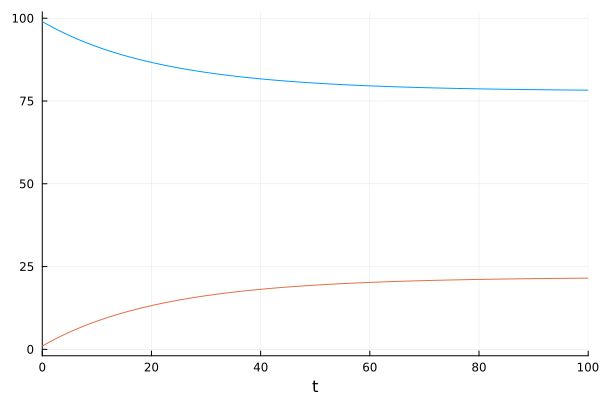

In [17]:
gr()
ode_plot = plot(sol; 
    idxs=[1, 2], # Specifies which solutions I care to be plotted
    # idxs=(1, 2), # Sets up our phase space, comparing solution 1 to solution 2
    leg = false,
    plotdensity=10_000 # Ensures the right dpi for plot appearence
    )

In [18]:
c₁ = c₁_of_t = sol[1,:] ; c₂ = c₂_of_t = sol[2,:]
cₜ = c₁ .+ c₂

c₁_percent = c₁_of_t ./ n₁ ; c₂_percent = c₂_of_t ./ n₂
c_percent = c₁_percent .+ c₂_percent;

In [19]:
cₜ

108-element Vector{Float64}:
 99.99
 99.98999974621317
 99.989990405122
 99.98994692285227
 99.98985532924061
 99.98968525689413
 99.98942390674826
 99.98904809921375
 99.9885511181712
 99.98792301241157
  ⋮
 99.78503384865141
 99.78465341223566
 99.78430317546095
 99.78398191709375
 99.78368592448285
 99.7834111505827
 99.78315471815745
 99.78291504714342
 99.78283464623651

In [20]:
println(minimum(c_percent), "   " , maximum(c_percent))

1.0   1.0000436897241005


In [21]:
# @. n₂ * (1 - c₁ * n₁^-1)
# c₂

In [22]:
@. cₜ * (1/n₁ + 1/n₂)

108-element Vector{Float64}:
 2.0099
 2.0098999948986287
 2.0098998071332606
 2.0098989330957173
 2.009897091971604
 2.00989367334565
 2.009888419943728
 2.0098808658326806
 2.0098708760117243
 2.0098582504515052
 ⋮
 2.005779973321377
 2.005772326165141
 2.005765286052195
 2.005758828434511
 2.0057528786840493
 2.0057473554511067
 2.0057422009003365
 2.005737383270863
 2.0057357671314207

In [24]:
c_q = 2*n₁*n₂ /(n₁+n₂)

99.49748743718592

In [25]:
c_q / n₁

0.9949748743718593

In [26]:
#dc₁ = c₁ -> (ω[1,1]-f[1,1]*c_q) * c₁ + w₂*(c_q - c₁)
#dc₁(c_f);

In [27]:
total_percents = cₜ ./ c_percent;

In [28]:
c₁_f = -(w₂*c_q) / ((ω[1,1] - f[1,1] * c_q) - w₂)

99.74811083123443

In [29]:
c₂_f = (n₁ - c₁_f)

0.25188916876557244

In [30]:
c₂_fixed = -(w₁ * n₁)/ (ω[2,2] - f[2,2] * n₁ - w₁)

19.919517102615636

In [31]:
# c₁_fixed = @. (-w₂*c₂)/(ω[1,1]-f[1,1] * cₜ);

In [32]:
c₁_fixed = -w₂/w₁ * ((n₁*n₂)/(n₁ + n₂))

-99.49748743718592

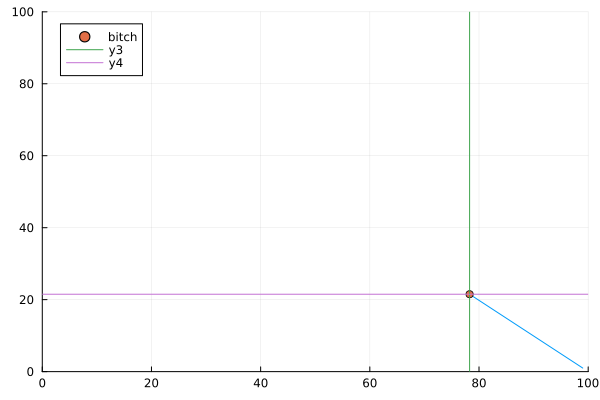

In [33]:
plot(sol; idxs=(1,2), plot_density=10_000, label=false)
scatter!((c₁[end], c₂[end]); label="bitch" )


vline!([c₁[end]])
hline!([c₂[end]])

xlims!(0,100)
ylims!(0,100)

In [34]:
2 * ((n₁*n₂) / (n₁ + n₂))

99.49748743718592

In [35]:
c_T = (n₁ + n₂) / 2

99.5

In [37]:
cT = c₁[end]+c₂[end]

99.78283464623651

In [38]:
c_T / n₁ + c_T / n₂

2.000050505050505

In [68]:
c₁/n₁

108-element Vector{Float64}:
 0.99
 0.9899510494832456
 0.9896963867790919
 0.9892756955480985
 0.9887845394054463
 0.9881710391782833
 0.9874697560197445
 0.9866654660182403
 0.9857742983523791
 0.9847940845223537
 ⋮
 0.7849244002409183
 0.784551798869852
 0.7842087727462771
 0.7838941265807671
 0.7836042245802016
 0.7833351031843471
 0.7830839445393087
 0.7828492013171098
 0.7827704556912021

In [70]:
c₂/n₂

108-element Vector{Float64}:
 0.01
 0.010049442402915144
 0.010306583103159773
 0.01073108452568095
 0.011226276653494746
 0.011844255950159654
 0.012549982876503012
 0.013358600983734462
 0.014253750332659583
 0.01523752080986055
 ⋮
 0.21507670529858167
 0.21544922752778228
 0.21579218081649737
 0.2161067601920914
 0.21639660067134028
 0.21666566497119186
 0.216916770345723
 0.21715146379224687
 0.2172301926981445

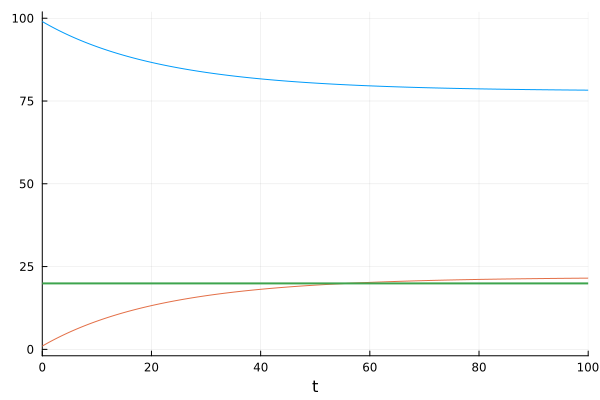

In [40]:
gr()
plot(ode_plot)
hline!([c₂_fixed]; linewidth=2)

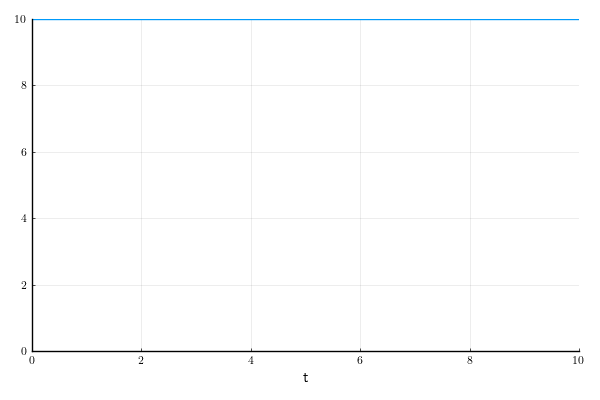

In [79]:
function temp_function(du, u, p, t)

    # More nightmare syntax, making du elementwise equal to this bitch
    du = [p.k₂*p.a - p.k₁*u[1]]
end;

α₀ = 10
u₀ₜ = [α₀]

a = 10
k₁ = 1
k₂ = 1

pₜ = (; a, k₁, k₂)

prob = ODEProblem(temp_function, u₀ₜ, (0,10), pₜ; tstops=t_span);
alg = Tsit5()
# alg = SIR54()
sol = solve(prob, alg; abstol=1e-10, reltol=1e-10);

plot(sol; plot_density=10_000, label=false)
ylims!(0,Inf+1)

## Quiver

In [42]:
function meshgrid_old(n)
    xs = ones(n) .* (1:n)'
    ys = xs'
    xys = permutedims(cat(xs, ys; dims = 3), [3, 1, 2])
    return reshape(xys, 2, n^2)
end;

In [43]:
meshgrid(x, y) = (repeat(x, outer=length(y)), repeat(y, inner=length(x)));

In [44]:
dc₁(c₁, c₂, m) = (p.ω[1,1] - p.f[1,1] * (c₁ + c₂) - q₁ * m) * c₁ + p.w₂ * c₂;
dc₂(c₁, c₂, m) = (p.ω[2,2] - p.f[2,2] * (c₁ + c₂)) * c₂ + p.w₁ * c₁;
dm(c₁, c₂, m)  = p.m₀ - p.qₘ * c₂ * m;

In [45]:
uc₁ = [ -(w₂ * c_q)/(ω[1,1] - f[1,1]*c_q - w₂); 0; 0]
uc₂ = [ -(w₂ * c_q)/(ω[1,1] - f[1,1]*c_q - w₂); 0; 0]

3-element Vector{Float64}:
 99.74811083123443
  0.0
  0.0

In [46]:
quiver_time_span = (0,150)

(0, 150)

In [47]:
quiver_prob = ODEProblem(func, uc₁, quiver_time_span, p; tstops=quiver_time_span);
quiver_sol  = solve(quiver_prob, alg)

retcode: Success
Interpolation: specialized 4th order "free" interpolation
t: 93-element Vector{Float64}:
   0.0
   0.0010025152020447846
   0.01102766722249263
   0.11127918742697107
   0.40366175371635693
   0.8613050510347482
   1.441593876386563
   2.242122690415125
   3.2882457687014366
   4.739684584381919
   ⋮
 136.77826803038081
 138.51625160684677
 140.25423530252908
 141.99221924989038
 143.73020306478907
 145.46818686644147
 147.20617065484763
 148.94415456247015
 150.0
u: 93-element Vector{Vector{Float64}}:
 [99.74811083123443, 0.0, 0.0]
 [99.74761412238165, 0.0009999698820470663, 0.0]
 [99.74259330958125, 0.010997452725717111, 0.0]
 [99.68740839764224, 0.11074531398074494, 0.0]
 [99.48706758231984, 0.39915131587548947, 0.0]
 [99.10785148473008, 0.8425793057547102, 0.0]
 [98.5857903865506, 1.3905340080186113, 0.0]
 [97.85940360844499, 2.1208160954883923, 0.0]
 [96.940876689207, 3.0324286485333554, 0.0]
 [95.73921023045449, 4.222085376093509, 0.0]
 ⋮
 [78.01526378310729, 21.

In [48]:
#c₁_null = @. dc₁(-(w₂*c_q) / )
#c₂_null = dc₂()

In [50]:
z_norm = @. sqrt.(c₁_vecs^2 + c₂_vecs^2);
quiver_plot = contour(c₁_vecs, c₂_vecs, z_norm)

UndefVarError: UndefVarError: `c₁_vecs` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [51]:
# grid = abs.(meshgrid(40) ./ 2 .- [1; 99])
x_range = 0:2:100
y_range = 0:2:100

x, y = meshgrid(x_range, y_range);

In [52]:
scaling_const = 1/100;

c₁_vecs = @. dc₁(x, y, 0) * scaling_const;
c₂_vecs = @. dc₂(x, y, 0) * scaling_const;

/home/anakin/.julia/artifacts/872754c2f795d19a3e2e205b2bbaea659f28d11e/lib/libudev.so: version `LIBUDEV_247' not found (required by /lib/x86_64-linux-gnu/libgudev-1.0.so.0)
Failed to load module: /usr/lib/x86_64-linux-gnu/gtk-4.0/4.0.0/media/libmedia-gstreamer.so


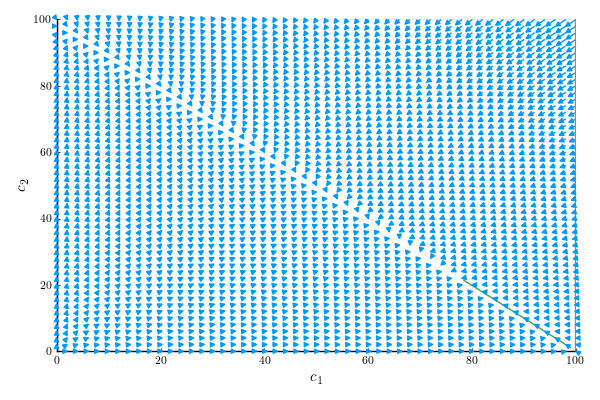

In [53]:
pyplot()
quiver_plot = quiver(x, y, quiver=(c₁_vecs, c₂_vecs))
xlims!(0,100)
ylims!(0,100)


xlabel!(L"c_1")
ylabel!(L"c_2")

vline!([uc₁[1:2]...]; leg=false)
plot!(c₁, c₂)
# plot!(quiver_sol; 
#     color=:black,
#     leg=false, idxs=(2,1), plotdensity=10_000
# )

### With GMT

In [54]:
# using GMT

In [55]:
# xx, yy = GMT.meshgrid(x_range, y_range)

In [56]:
U = dc₁.(xx, yy, 0)
V = dc₂.(xx, yy, 0)

UndefVarError: UndefVarError: `xx` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [57]:
p = quiver(x, y, quiver=(U,V))
plot(p; show=true)

UndefVarError: UndefVarError: `U` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [58]:
startx = linspace(0,100,100)
starty = zeros(length(startx))

p = streamlines(U, V, startx, starty)
plot(p, show=true)

UndefVarError: UndefVarError: `linspace` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [59]:
# U = mat2grid(dc₁.(xx, yy, 0), )

In [60]:
for (i, sign) ∈ enumerate([-, +])
    println(sign(2, 1))
end;

1
3


In [61]:
a = f[1,1]*((n₁ - n₂)/n₁);
b = ω[1,1] * (n₂/n₁) + ω[1,2];
c = w₁*n₂;

In [62]:
function roots(a,b,c)
    output = Vector{Union{Float64,Missing}}(undef, 2)

    for (i, sign) ∈ enumerate([-, +])
        disc = b^2 - 4 * a * c
        back = sqrt(disc) / (2 * a)

        front = -b / (2 * a)

        output[i] = sign(front, back)
    end

    return output
end;

In [63]:
λ = roots(a, b, c)

2-element Vector{Union{Missing, Float64}}:
 -19750.249370253143
     -0.25062974685533845